In [1]:
import skimage
import numpy as np
import os
from skimage import io
from skimage import color
from skimage import util 
from skimage.viewer import ImageViewer
import warnings
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
io.use_plugin('matplotlib')
%matplotlib inline

Generate positions of particles, as vector of (X, Y, Z, R) where (X, Y, Z) coordinates in 3D and R is radius of a particle.

In [2]:
num_part = 30

X_min, X_max = -100, 100
Y_min, Y_max = -100, 100
Z_min, Z_max = -10, 10

mean_R = 2
sigma_R = 0.5

X = X_min + np.random.rand(num_part) * (X_max - X_min)
Y = Y_min + np.random.rand(num_part) * (Y_max - Y_min)
Z = Z_min + np.random.rand(num_part) * (Z_max - Z_min)

R = np.random.normal(mean_R, sigma_R**2, num_part)

particles_3d = np.vstack([X, Y ,Z, R]).T


In [3]:
def generate_particles(num_part, X_min=-100, X_max=100, Y_min=-100, Y_max=100, Z_min=-10, Z_max=10, mean_R=2, sigma_R=0.5):
    X = X_min + np.random.rand(num_part) * (X_max - X_min)
    Y = Y_min + np.random.rand(num_part) * (Y_max - Y_min)
    Z = Z_min + np.random.rand(num_part) * (Z_max - Z_min)

    R = np.random.normal(mean_R, sigma_R**2, num_part)

    particles_3d = np.vstack([X, Y ,Z, R]).T
    
    return particles_3d
    

In [4]:
X_min, X_max = -100, 100
Y_min, Y_max = -100, 100
Z_min, Z_max = -10, 10

mean_R = 2
sigma_R = 0.5

particles_3d =  []
for x in (X_min, X_max):
    for y in (Y_min, Y_max):
        for z in (Z_min, Z_max):
            particles_3d.append(np.array([x ,y ,z , 0.5]))
            
particles_3d = np.vstack(particles_3d)
particles_3d

array([[-100. , -100. ,  -10. ,    0.5],
       [-100. , -100. ,   10. ,    0.5],
       [-100. ,  100. ,  -10. ,    0.5],
       [-100. ,  100. ,   10. ,    0.5],
       [ 100. , -100. ,  -10. ,    0.5],
       [ 100. , -100. ,   10. ,    0.5],
       [ 100. ,  100. ,  -10. ,    0.5],
       [ 100. ,  100. ,   10. ,    0.5]])

R distribution

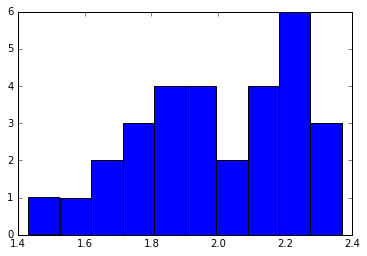

In [5]:
plt.hist(R);

3D to 2D

In [6]:
def particles_3d_to_2d(particles_3d, d0=100, di=50):
    """
    Convert 4d array (X, Y, Z, R) of particles to 3d array (x ,y, r). 
    
    Parameters
    ----------
    particles_3d - array of (X, Y, Z, R).
    d0 - distance to lens.
    di - distance from lens to camera.
    """
    
    x = particles_3d[:,0] * di / (d0 - particles_3d[:,2])
    y = particles_3d[:,1] * di / (d0 - particles_3d[:,2])
    r = particles_3d[:,3] * di / (d0 - particles_3d[:,2])
    
    particles_2d = np.vstack([x, y, r]).T
    
    return particles_2d


In [7]:
import scipy 

def particle_intensity(x_p, y_p, r_p, x, y, fr_x=1, fr_y=1, px_sigma=1, py_sigma=1):
    """
    Return intensity of particles (which is placed in point (x_p, y_p)) in point (x, y) of Image.
    (0, 0) of Image in the center of the Image.
    Parameters
    ----------
    x_p - x-coordinate of a particle.
    y_p - x-coordinate of a particle.
    r_p - radius of particle.
    x - coordinate of image.
    y - coordinate of image.
    fr_x - indicate the ratio of the sensitive area of 1 pixel to the pixel pitch, 
            varying in a range between 0.0 and 1.0 (x axis).
    fr_y - indicate the ratio of the sensitive area of 1 pixel to the pixel pitch, 
            varying in a range between 0.0 and 1.0 (y axis).
    px_sigma - width of the 2D gaussian intensity distribution (x axis).
    py_sigma - width of the 2D gaussian intensity distribution (y axis).
    """
    
    I = np.pi * (2.0 *r_p)**2 *px_sigma*px_sigma* (1.0/ 8.0)*((scipy.special.erf((x - x_p + fr_x / 2.0) / (px_sigma * np.sqrt(2.0)) ) - scipy.special.erf((x - x_p - fr_x / 2.0) / (px_sigma * np.sqrt(2.0)))) *  
            (scipy.special.erf((y - y_p + fr_y / 2.0) / (py_sigma * np.sqrt(2.0)) ) - scipy.special.erf((y - y_p - fr_y / 2.0) / (py_sigma * np.sqrt(2.0)))))
    
    return I

In [8]:
# def plot_particles(particles_2d, w=100, h=100):
#     map_p = np.zeros((w, h))

#     for x in range(w):
#         for y in range(h):
#             for p in particles_2d:

#                 map_p[x, y] += particle_intensity(p[0], p[1], p[2], x - w/2.0, y - h/2.0, fr_x=0.75, fr_y=0.75, 
#                                                   px_sigma=0.9, py_sigma=0.9 )
                
#     return map_p / map_p.max()
    
    
def plot_particles(particles_2d, w=100, h=100):
    map_p = np.zeros((w, h))


    for p in particles_2d:
        x_min = int(max(0, p[0] - 2*p[2] + w/2.0,))
        x_max = int(min(w - 1, p[0] + 2*p[2] + w/2.0, ))
        y_min = int(max(0, p[1] - 2*p[2]+ w/2.0))
        y_max = int(min(h - 1, p[1] + 2*p[2] + w/2.0))
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                map_p[x, y] += particle_intensity(p[0], p[1], p[2], x - w/2.0, y - h/2.0, fr_x=0.75, fr_y=0.75, 
                                                  px_sigma=0.9, py_sigma=0.9 )
                
    return map_p / map_p.max()

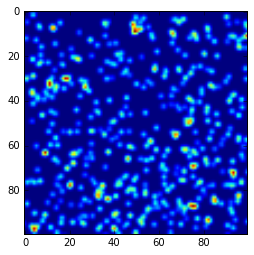

In [9]:
particels_3d = generate_particles(500)
particles_2d = particles_3d_to_2d(particels_3d)
img = plot_particles(particles_2d)

plt.imshow(img)

In [10]:
path = 'generated_particles'
for i in range(100):
    particels_3d = generate_particles(500)
    particles_2d = particles_3d_to_2d(particels_3d)
    img = plot_particles(particles_2d)

    io.imsave(path + '/' + str(i).zfill(5) + '.png', img)
    
    df = pd.DataFrame(particles_2d, columns=['x', 'y', 'r'])
    df.to_csv(path + '/' + str(i).zfill(5) + '.csv', index=None)

NameError: name 'pd' is not defined